In [1]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cpu.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cpu.html
     |████████████████████████████████| 292 kB 5.7 MB/s 
     |████████████████████████████████| 648 kB 22.2 MB/s 
     |████████████████████████████████| 317 kB 27.9 MB/s 
     |████████████████████████████████| 140 kB 12.7 MB/s 
     |████████████████████████████████| 407 kB 4.1 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=ec6a0ecba0184877b77b03a20eed88da33e8cdae623cb7cdb99b910c83a5a4ed
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [2]:
%matplotlib inline

from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
import os
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

![img](https://graphsandnetworks.com/wp-content/uploads/2019/09/CoraBalloons.png)

In [3]:
#Load the dataset
dataset = 'cora'
path = os.path.join(os.getcwd(), 'data', 'Planetoid')
train_dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())

# Since the dataset is comprised of a single huge graph, 
# we extract that graph by indexing 0.
data = train_dataset[0]

# Since there is only 1 graph, the train/test split is 
# done by masking regions of the graph. We split the last 500+500 nodes 
# as val and test, and use the rest as the training data.
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:data.num_nodes - 1000] = 1
data.val_mask = None
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[data.num_nodes - 500:] = 1

Processing...
Done!


In [4]:
class Network(torch.nn.Module):
    def __init__(self, num_features, dim=16, num_classes=1):
        super(Network, self).__init__()
        self.conv1 = GCNConv(num_features, dim)
        self.conv2 = GCNConv(dim, num_classes)

    def forward(self, x, edge_index, data=None):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

    

In [5]:
epochs = 200
dim = 16 

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Network(num_features=train_dataset.num_features,\
            dim=dim, num_classes=train_dataset.num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

In [13]:
for t in model.parameters():
  print(t)

Parameter containing:
tensor([ 4.9933e-02, -4.4160e-03,  1.0246e-01,  3.9705e-02,  1.0048e-01,
         1.4068e-01,  1.3704e-01,  1.6295e-02,  2.9191e-02,  1.0935e-05,
         7.8219e-02,  1.1678e-01,  7.4655e-02, -2.4352e-03,  4.7722e-02,
         7.7246e-02], requires_grad=True)
Parameter containing:
tensor([[-1.1526e-02,  1.1057e-02, -1.6177e-02,  ...,  8.6463e-04,
         -2.4407e-02,  1.0108e-02],
        [ 8.6416e-07,  1.3368e-06,  3.2446e-07,  ...,  4.1085e-07,
         -3.2649e-07, -8.1804e-07],
        [-3.1768e-03,  2.6111e-04,  6.5403e-03,  ..., -4.7769e-04,
         -3.1667e-03,  3.5198e-02],
        ...,
        [-1.8746e-07,  1.8407e-07, -1.2634e-07,  ...,  3.1878e-07,
         -7.1553e-07,  1.4720e-06],
        [-1.1755e-02,  1.2683e-02, -4.9173e-02,  ..., -8.5445e-03,
         -5.0454e-02,  3.3893e-03],
        [ 4.3643e-03, -2.1714e-03, -4.4452e-04,  ...,  2.2692e-03,
         -7.3353e-03, -1.2941e-02]], requires_grad=True)
Parameter containing:
tensor([-0.0500, -0.4

In [7]:
device

device(type='cpu')

In [8]:
def test(model, data):
    model.eval()
    logits, accs = model(data.x, data.edge_index, data), []
    for _, mask in data('train_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [9]:
loss = 999.0
train_acc = 0.0
test_acc = 0.0

t = trange(epochs, desc="Stats: ", position=0)

for epoch in t:

    model.train()
    
    loss = 0

    data = data.to(device)
    optimizer.zero_grad()
    log_logits = model(data.x, data.edge_index, data)

    # Since the data is a single huge graph, training on the training set 
    #is done by masking the nodes that are not in the training set.
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # validate
    train_acc, test_acc = test(model, data)
    train_loss = loss
    
    t.set_description('[Train_loss:{:.6f} Train_acc: {:.4f}, Test_acc: {:.4f}]'.format(loss, train_acc, test_acc))
    

[Train_loss:1.572080 Train_acc: 0.4286, Test_acc: 0.4400]: 100%|██████████| 200/200 [00:16<00:00, 11.88it/s]


In [10]:
node_idx = 10
x, edge_index = data.x, data.edge_index
explainer = GNNExplainer(model, epochs=200)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)

Explain node 10: 100%|██████████| 200/200 [00:01<00:00, 161.59it/s]


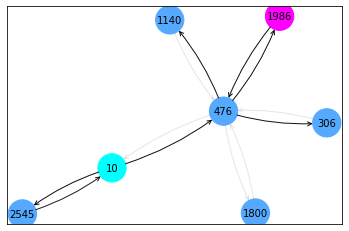

In [11]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()